# Détection de Fraude dans les Transactions Crypto/Web3

## Contexte et Objectif

Ce notebook présente **deux approches** de détection de transactions frauduleuses dans le domaine des cryptomonnaies et du Web3 :

- **PARTIE A** : Approche supervisée avec labels synthétiques
- **PARTIE B** : Approche réaliste sans labels (non supervisé → pseudo-labels → supervisé)

**Source des données :** Dataset Kaggle "Synthetic Crypto/Web3 Transaction Dataset"  
**Fichier local utilisé :** `data/raw/crypto_transactions.csv`  
**Note :** Les données sont synthétiques et servent à des fins pédagogiques.

### Description des colonnes disponibles

- **tx_hash** : Hash unique de la transaction
- **from_wallet** : Adresse source de la transaction
- **to_wallet** : Adresse de destination
- **token** : Type de token (DAI, USDC, ETH, etc.)
- **amount** : Montant de la transaction
- **timestamp** : Date et heure de la transaction
- **gas_fee_usd** : Coût en gas en USD
- **platform** : Plateforme utilisée (Uniswap, Compound, etc.)
- **tx_type** : Type de transaction (transfer, swap, lend, stake, etc.)

**Important :** Le dataset ne contient **pas de labels de fraude**. Nous allons créer des labels synthétiques dans la Partie A pour illustrer un pipeline supervisé puis utiliser une approche non supervisée dans la Partie B.


In [35]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, precision_score, recall_score

# Configuration pour la reproductibilité
np.random.seed(42)

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## Chargement des données

Nous chargeons le fichier CSV local qui contient les transactions crypto synthétiques.  
**Chemin :** `/data/raw/crypto_transactions.csv`

Après le chargement, nous examinerons :
- La structure du dataset (nombre de lignes, colonnes)
- Les types de données
- La présence de valeurs manquantes
- Les statistiques descriptives

In [36]:
# Chargement du dataset brut
df_raw = pd.read_csv('../data/raw/crypto_transactions.csv')

# Affichage des premières lignes
print("=== Premières lignes du dataset ===")
df_raw.head()


=== Premières lignes du dataset ===


,tx_hash,from_wallet,to_wallet,token,amount,timestamp,gas_fee_usd,platform,tx_type
0,0xc40e0b25086f94703e134ffc6cab543321f7610c0302...,0xd99d937bfcbe7f83bc761bf0fe3316fdfde27202,0x3d3d6ad4dc669c598c31454a3f73410da25922fe,DAI,4.466987,2022-03-13 21:56:21,0.7288,Compound,transfer
1,0x2e32672b7ccb2c55db06c91ca17122dea7c1c6f7f848...,0x20ad73be3c5ec493f2033ff9bc7d60fb5d4cdb95,0x3d6f42ea21ae34d48eec8a53991b4020047d491c,UNI,2.367266,2022-01-03 14:56:17,0.5694,Sushiswap,lend
2,0x3d2cde2b23d28e641a6d5f2e013f0507213c00ca34ef...,0x52e3343a7b26c07e6dd7f3c16b3a79cf496123b7,0x92cf01d92fa41776ad2493336066dc55d6e69a96,UNI,5.194958,2022-01-08 21:43:49,2.5620,Uniswap,stake
3,0x21c59e7a4f0fc4b1d7b5675e6c8416d0ac0f6b85ed8b...,0x93bc0e6b2790e4ddd7c3c8779e218ed2b3ecee40,0xca80b638cb4ea61cf1ff18e788731ae99e214372,SHIB,12.466311,2022-07-22 13:45:23,3.9805,Curve,lend
4,0x37a1cc6eab2bf725091ea66a44625e34c76eb005f5dc...,0x4ebcc8d240d2e3be0bc39c5485ea707fec7007d0,0xbcee8de49ec86476ab995cff4c8d06f15ba95062,USDC,2.150815,2022-08-26 12:15:31,0.3482,Compound,transfer


In [37]:
# Informations sur le dataset
print("=== Informations sur le dataset ===")
df_raw.info()


# Résumé du dataset
n_rows, n_cols = df_raw.shape
missing_total = df_raw.isna().sum().sum()
missing_per_col = df_raw.isna().sum()

print("=== Résumé du dataset ===")
print(f"Nombre de lignes : {n_rows}")
print(f"Nombre de colonnes : {n_cols}")
print(f"Nombre total de valeurs manquantes : {missing_total}")
print("\nValeurs manquantes par colonne :")
print(missing_per_col)

=== Informations sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tx_hash      500000 non-null  object 
 1   from_wallet  500000 non-null  object 
 2   to_wallet    500000 non-null  object 
 3   token        500000 non-null  object 
 4   amount       500000 non-null  float64
 5   timestamp    500000 non-null  object 
 6   gas_fee_usd  500000 non-null  float64
 7   platform     500000 non-null  object 
 8   tx_type      500000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 34.3+ MB
=== Résumé du dataset ===
Nombre de lignes : 500000
Nombre de colonnes : 9
Nombre total de valeurs manquantes : 0

Valeurs manquantes par colonne :
tx_hash        0
from_wallet    0
to_wallet      0
token          0
amount         0
timestamp      0
gas_fee_usd    0
platform       0
tx_type        0
dtype: int64


In [38]:
# Statistiques descriptives
print("=== Statistiques descriptives ===")
df_raw.describe(include='all')


=== Statistiques descriptives ===


,tx_hash,from_wallet,to_wallet,token,amount,timestamp,gas_fee_usd,platform,tx_type
count,500000,500000,500000,500000,500000.000000,500000,500000.000000,500000,500000
unique,500000,10000,10000,10,NaN,496036,NaN,8,7
top,0xc40e0b25086f94703e134ffc6cab543321f7610c0302...,0x5c7b7b76fe48527229ea6bf2aeec7a6c88141726,0x865067d197da55ccac5a3e7a2968c973a97a4082,USDT,NaN,2022-12-14 05:26:46,NaN,Sushiswap,lend
freq,1,80,80,50434,NaN,3,NaN,62876,71793
mean,NaN,NaN,NaN,NaN,4.474251,NaN,2.003641,NaN,NaN
std,NaN,NaN,NaN,NaN,5.797250,NaN,2.004919,NaN,NaN
min,NaN,NaN,NaN,NaN,0.021722,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.381195,NaN,0.576700,NaN,NaN
50%,NaN,NaN,NaN,NaN,2.715279,NaN,1.387700,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.332680,NaN,2.775600,NaN,NaN


### Préparation des données et division train/test

Avant de créer les labels synthétiques, nous divisons les données en ensembles d'entraînement et de test. Cette séparation préalable garantit que les seuils utilisés pour construire les labels (percentiles, etc.) sont calculés uniquement sur le train set, évitant ainsi toute fuite de données vers le test set.


In [39]:
# Division train/test AVANT la création des labels
# On utilise random_state=42 pour la reproductibilité
df_train, df_test = train_test_split(
    df_raw, 
    test_size=0.2, 
    random_state=42
)

# Sécurise les affectations futures (évite SettingWithCopy warnings)
df_train = df_train.copy()
df_test = df_test.copy()

print(f"Train set : {df_train.shape[0]} échantillons")
print(f"Test set : {df_test.shape[0]} échantillons")


Train set : 400000 échantillons
Test set : 100000 échantillons


Ces informations nous permettent de comprendre la taille du dataset et d'identifier d'éventuels problèmes de qualité des données avant de procéder à l'analyse exploratoire.

## PARTIE A - Approche Supervisée avec Labels Synthétiques

Dans cette première partie, nous allons créer des labels synthétiques pour illustrer un pipeline de machine learning supervisé classique. Cette approche est **pédagogique** : dans la réalité, on n'a généralement pas de labels de fraude disponibles.


### Construction de la cible (Label Engineering)

Le dataset ne contient pas de colonne `is_suspicious`. Pour illustrer un pipeline supervisé, nous créons une cible synthétique basée sur des règles simples et explicables :

1. **Transactions avec montants très élevés ou très faibles** (percentiles extrêmes sur `amount`)
2. **Transactions avec frais de gas anormalement élevés** (percentile élevé sur `gas_fee_usd`)
3. **Self-transfers** (`from_wallet == to_wallet`) : souvent associés à des comportements suspects

**Important :** Les seuils (percentiles) sont calculés **uniquement sur le train set** pour éviter toute fuite de données. Ces mêmes seuils sont ensuite appliqués au test set.


In [40]:
# Calcul des seuils UNIQUEMENT sur le train set
# Règle 1 : Montants très élevés (> 95e percentile) ou très faibles (< 5e percentile)
amount_p95 = df_train['amount'].quantile(0.95)
amount_p05 = df_train['amount'].quantile(0.05)

# Règle 2 : Frais de gas très élevés (> 90e percentile)
gas_p90 = df_train['gas_fee_usd'].quantile(0.90)

print("=== Seuils calculés sur le train set ===")
print(f"Montant 95e percentile : {amount_p95:.2f}")
print(f"Montant 5e percentile : {amount_p05:.2f}")
print(f"Gas fee 90e percentile : {gas_p90:.2f} USD")

# Feature explicite (observable par le modèle)
df_train["is_self_transfer"] = (df_train["from_wallet"] == df_train["to_wallet"]).astype(int)
df_test["is_self_transfer"]  = (df_test["from_wallet"] == df_test["to_wallet"]).astype(int)

# (Optionnel) check rapide
print("Self-transfer rate (train):", df_train["is_self_transfer"].mean())
print("Self-transfer rate (test):", df_test["is_self_transfer"].mean())

# Application des règles sur le train set
df_train['is_suspicious'] = (
    (df_train['amount'] > amount_p95) | 
    (df_train['amount'] < amount_p05) | 
    (df_train['gas_fee_usd'] > gas_p90) | 
    (df_train['is_self_transfer'] == 1)
).astype(int)

# Application des MÊMES seuils sur le test set (sans recalculer les percentiles)
df_test['is_suspicious'] = (
    (df_test['amount'] > amount_p95) | 
    (df_test['amount'] < amount_p05) | 
    (df_test['gas_fee_usd'] > gas_p90) | 
    (df_test['is_self_transfer'] == 1)
).astype(int)

=== Seuils calculés sur le train set ===
Montant 95e percentile : 14.08
Montant 5e percentile : 0.53
Gas fee 90e percentile : 4.60 USD
Self-transfer rate (train): 0.0001025
Self-transfer rate (test): 0.00014


### Déséquilibre de classes - Train/Test
Examen de la distribution des classes dans les ensembles d'entraînement et de test pour comprendre le déséquilibre.

In [41]:
# Distribution des classes dans train et test
print("=== Train distribution (counts + %) ===")
train_counts = df_train['is_suspicious'].value_counts()
train_pct = df_train['is_suspicious'].value_counts(normalize=True) * 100
train_dist = pd.DataFrame({
    'Count': train_counts,
    'Percentage': train_pct
})
print(train_dist)
print(f"\nProportion de transactions suspectes (train) : {df_train['is_suspicious'].mean():.4f} ({df_train['is_suspicious'].mean()*100:.2f}%)")

print("\n=== Test distribution (counts + %) ===")
test_counts = df_test['is_suspicious'].value_counts()
test_pct = df_test['is_suspicious'].value_counts(normalize=True) * 100
test_dist = pd.DataFrame({
    'Count': test_counts,
    'Percentage': test_pct
})
print(test_dist)
print(f"\nProportion de transactions suspectes (test) : {df_test['is_suspicious'].mean():.4f} ({df_test['is_suspicious'].mean()*100:.2f}%)")

=== Train distribution (counts + %) ===
                Count  Percentage
is_suspicious                    
0              324004      81.001
1               75996      18.999

Proportion de transactions suspectes (train) : 0.1900 (19.00%)

=== Test distribution (counts + %) ===
               Count  Percentage
is_suspicious                   
0              80784      80.784
1              19216      19.216

Proportion de transactions suspectes (test) : 0.1922 (19.22%)



=== Distribution de is_suspicious ===
is_suspicious
0    404788
1     95212
Name: count, dtype: int64

Pourcentage de transactions suspectes : 19.04%

Règles appliquées :
- Montant > 14.08 (95e percentile) : 24966 transactions
- Montant < 0.53 (5e percentile) : 25091 transactions
- Gas fee > 4.60 USD (90e percentile) : 50188 transactions
- Self-transfers : 55 transactions


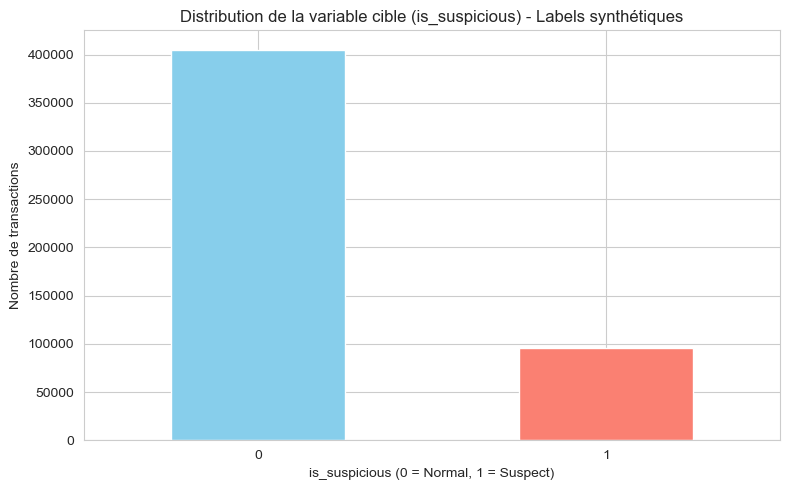

In [42]:
# Réunion des données pour l'EDA (sans recalculer les seuils)
df_full = pd.concat([df_train, df_test], ignore_index=True)

# Affichage de la distribution
print("\n=== Distribution de is_suspicious ===")
print(df_full['is_suspicious'].value_counts())
print(f"\nPourcentage de transactions suspectes : {df_full['is_suspicious'].mean()*100:.2f}%")
print(f"\nRègles appliquées :")
print(f"- Montant > {amount_p95:.2f} (95e percentile) : {(df_full['amount'] > amount_p95).sum()} transactions")
print(f"- Montant < {amount_p05:.2f} (5e percentile) : {(df_full['amount'] < amount_p05).sum()} transactions")
print(f"- Gas fee > {gas_p90:.2f} USD (90e percentile) : {(df_full['gas_fee_usd'] > gas_p90).sum()} transactions")
print(f"- Self-transfers : {(df_full['from_wallet'] == df_full['to_wallet']).sum()} transactions")

# Visualisation
plt.figure(figsize=(8, 5))
df_full['is_suspicious'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution de la variable cible (is_suspicious) - Labels synthétiques')
plt.xlabel('is_suspicious (0 = Normal, 1 = Suspect)')
plt.ylabel('Nombre de transactions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Analyse Exploratoire des Données (EDA) — Partie A

L'analyse exploratoire nous permet de :
1. Comprendre la distribution de la variable cible (`is_suspicious`)
2. Identifier les patterns dans les types de transactions
3. Comparer les caractéristiques des transactions suspectes vs normales
4. Découvrir les corrélations entre les variables numériques

Ces insights guideront notre choix de features et notre compréhension du problème de fraude.


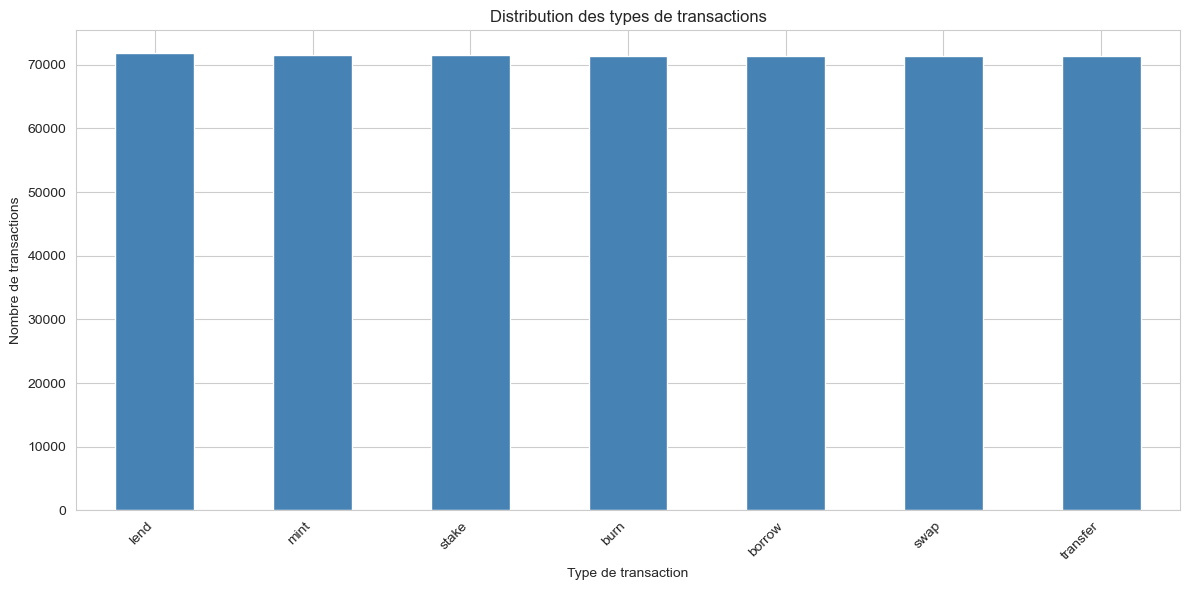

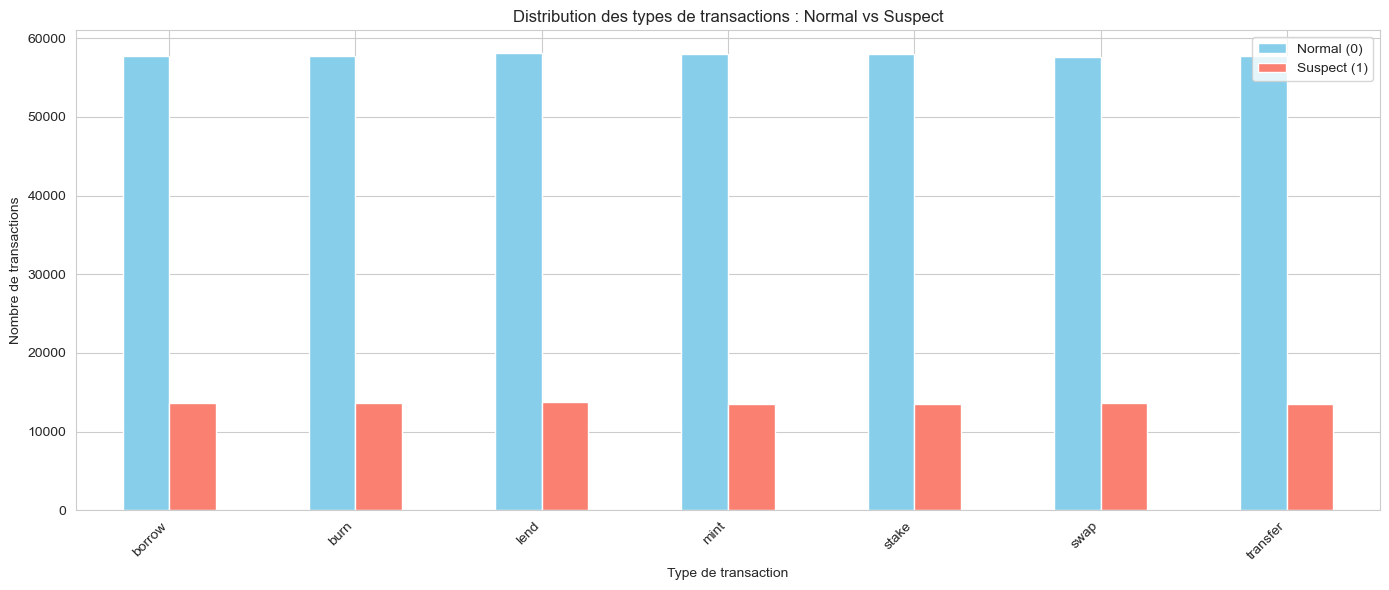

In [43]:
# Distribution des types de transactions (tx_type)
plt.figure(figsize=(12, 6))
tx_counts = df_full['tx_type'].value_counts()
tx_counts.plot(kind='bar', color='steelblue')
plt.title('Distribution des types de transactions')
plt.xlabel('Type de transaction')
plt.ylabel('Nombre de transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Distribution de tx_type en fonction de is_suspicious
plt.figure(figsize=(14, 6))
ax = plt.gca()
pd.crosstab(df_full['tx_type'], df_full['is_suspicious']).plot(kind='bar', stacked=False, color=['skyblue', 'salmon'], ax=ax)
ax.set_title('Distribution des types de transactions : Normal vs Suspect')
ax.set_xlabel('Type de transaction')
ax.set_ylabel('Nombre de transactions')
ax.legend(['Normal (0)', 'Suspect (1)'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Interprétation :** Certains types de transactions peuvent être plus associés à la fraude que d'autres selon nos règles synthétiques.


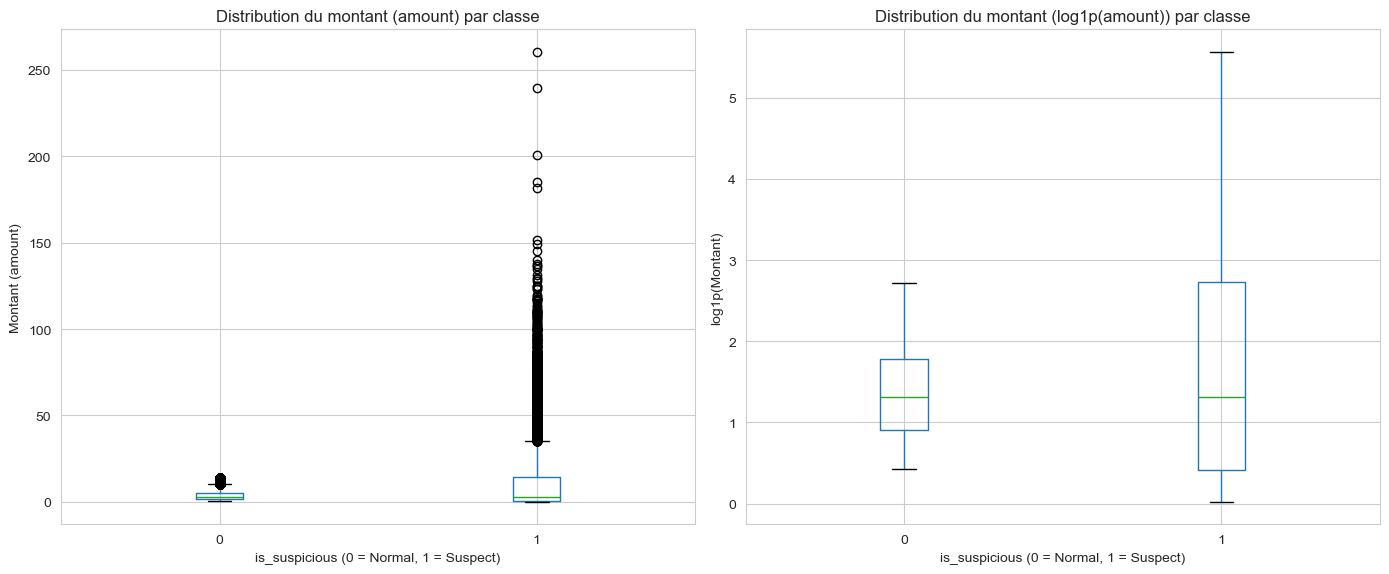

In [44]:
# Distribution du montant (amount) : comparaison suspect vs normal - Boxplot
# Note : Le boxplot peut être écrasé à cause des valeurs extrêmes. 
# Pour l'EDA uniquement, on utilise log1p pour mieux visualiser sans modifier les données d'entraînement.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot original (peut être écrasé)
df_full.boxplot(column='amount', by='is_suspicious', ax=axes[0])
axes[0].set_title('Distribution du montant (amount) par classe')
axes[0].set_xlabel('is_suspicious (0 = Normal, 1 = Suspect)')
axes[0].set_ylabel('Montant (amount)')

# Boxplot avec log1p pour meilleure lisibilité (EDA uniquement, pas utilisé pour l'entraînement)
df_full['amount_log1p'] = np.log1p(df_full['amount'])
df_full.boxplot(column='amount_log1p', by='is_suspicious', ax=axes[1])
axes[1].set_title('Distribution du montant (log1p(amount)) par classe')
axes[1].set_xlabel('is_suspicious (0 = Normal, 1 = Suspect)')
axes[1].set_ylabel('log1p(Montant)')
plt.suptitle('')  # Supprime le titre automatique
plt.tight_layout()
plt.show()

# Suppression de la colonne temporaire (pas utilisée pour l'entraînement)
df_full.drop(columns=['amount_log1p'], inplace=True)


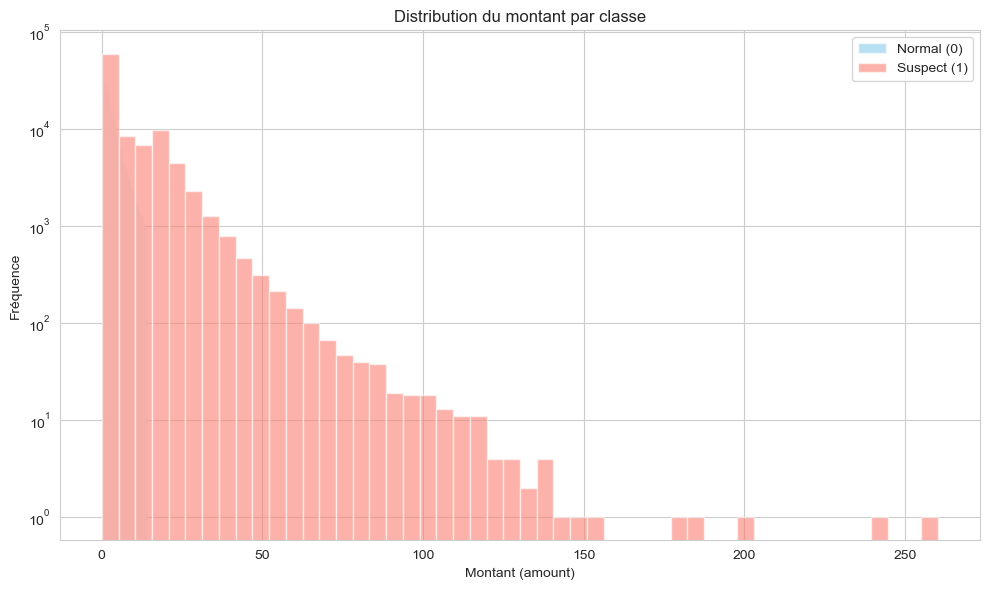

In [45]:
# Distribution du montant (amount) : comparaison suspect vs normal - Histogrammes
plt.figure(figsize=(10, 6))
df_full[df_full['is_suspicious'] == 0]['amount'].hist(alpha=0.6, label='Normal (0)', bins=50, color='skyblue')
df_full[df_full['is_suspicious'] == 1]['amount'].hist(alpha=0.6, label='Suspect (1)', bins=50, color='salmon')
plt.xlabel('Montant (amount)')
plt.ylabel('Fréquence')
plt.title('Distribution du montant par classe')
plt.legend()
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser
plt.tight_layout()
plt.show()


**Interprétation :** Les transactions suspectes (selon nos règles synthétiques) montrent des montants plus extrêmes, ce qui est attendu puisque nous avons utilisé les percentiles extrêmes pour créer les labels. Cela suggère que `amount` est une feature informative pour la détection de fraude.


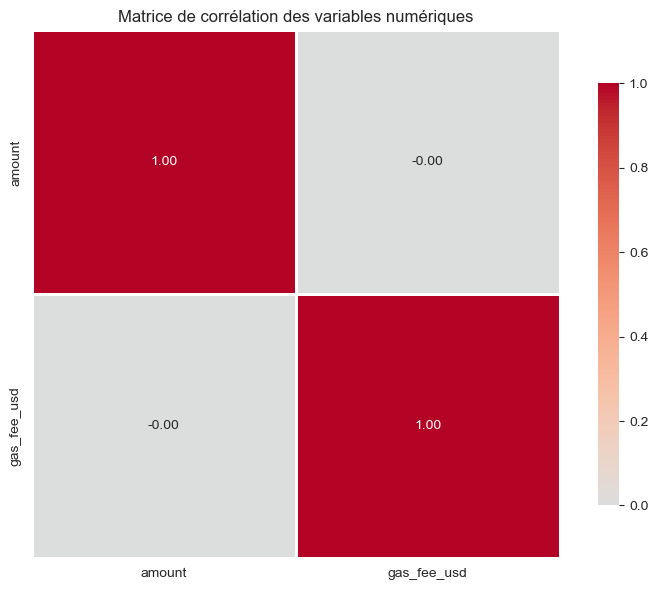

In [46]:
# Heatmap de corrélation pour les variables numériques
numerical_cols = ['amount', 'gas_fee_usd']
correlation_matrix = df_full[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()


**Interprétation :** La matrice de corrélation permet d'identifier les variables fortement corrélées. Une forte corrélation entre deux features peut indiquer de la redondance. Ici, `amount` et `gas_fee_usd` peuvent être corrélés si les transactions importantes nécessitent plus de gas. Ces deux variables sont utilisées comme features numériques dans notre modèle.

### Préprocessing et Préparation des Données - Partie A

Pour entraîner nos modèles, nous devons :
1. **Séparer la cible** (`is_suspicious`) des features
2. **Sélectionner les features** pertinentes (en excluant les adresses brutes pour simplifier) :
   - Catégorielles : `token`, `platform`, `tx_type`
   - Numériques : `amount`, `gas_fee_usd`
3. **Créer un pipeline de préprocessing** avec :
   - Encodage One-Hot pour les variables catégorielles
   - Standardisation pour les variables numériques
4. **Nous conservons le split train/test initial** (réalisé avant la création des labels pour éviter le leakage).
La stratification n’est donc pas applicable à ce stade puisque la cible n’existait pas encore.

**Note :** Nous utilisons un `ColumnTransformer` combiné avec un `Pipeline` sklearn pour garantir la reproductibilité et éviter les fuites de données.


In [47]:
# Sélection des features
# Catégorielles
categorical_features = ['token', 'platform', 'tx_type']
# Numériques
numerical_features = ['amount', 'gas_fee_usd', 'is_self_transfer']

print(f"\nFeatures catégorielles : {categorical_features}")
print(f"Features numériques : {numerical_features}")



Features catégorielles : ['token', 'platform', 'tx_type']
Features numériques : ['amount', 'gas_fee_usd', 'is_self_transfer']


In [48]:
# Création du préprocesseur avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='drop'
)

print("Préprocesseur créé avec succès")
print(f"- Encodage One-Hot pour : {categorical_features}")
print(f"- Standardisation pour : {numerical_features}")


Préprocesseur créé avec succès
- Encodage One-Hot pour : ['token', 'platform', 'tx_type']
- Standardisation pour : ['amount', 'gas_fee_usd', 'is_self_transfer']


In [49]:
# Reconstruction des ensembles train/test
# Les labels ont déjà été créés sur les bons ensembles, nous reconstruisons X et y
X_train = df_train[categorical_features + numerical_features]
y_train = df_train['is_suspicious']
X_test = df_test[categorical_features + numerical_features]
y_test = df_test['is_suspicious']

print(f"Taille du train set : {X_train.shape[0]} échantillons")
print(f"Taille du test set : {X_test.shape[0]} échantillons")
print(f"\nProportion de transactions suspectes dans le train : {y_train.mean():.3f}")
print(f"Proportion de transactions suspectes dans le test : {y_test.mean():.3f}")


Taille du train set : 400000 échantillons
Taille du test set : 100000 échantillons

Proportion de transactions suspectes dans le train : 0.190
Proportion de transactions suspectes dans le test : 0.192


## Modélisation

Nous allons entraîner et comparer deux modèles simples :

1. **Régression Logistique** : Modèle linéaire interprétable, bon baseline
2. **Random Forest** : Modèle non-linéaire qui capture les interactions entre features

Pour chaque modèle, nous utilisons un `Pipeline` sklearn qui combine le préprocesseur et le modèle. Cela garantit :
- Que le préprocessing est appliqué de manière cohérente
- Que le scaler est ajusté uniquement sur le train set (pas de data leakage)
- La reproductibilité et la facilité de déploiement

**Paramètres :**
- `random_state=42` pour la reproductibilité
- `max_iter=200` pour la régression logistique (suffisant pour la convergence)


### Modèle 1 : Régression Logistique


### Baseline naïve

Avant d'entraîner nos modèles supervisés, établissons une baseline simple : un modèle qui prédit toujours la classe majoritaire (0 = Normal). Cela nous permet de comprendre pourquoi l'accuracy seule est trompeuse dans un contexte de déséquilibre de classes.


In [50]:
# Baseline : prédire toujours 0 (classe majoritaire)
y_pred_baseline = np.zeros_like(y_test)

# Classification report
print("=== BASELINE NAÏVE (toujours prédire 0) ===\n")
print(classification_report(y_test, y_pred_baseline, target_names=['Normal (0)', 'Suspect (1)'], zero_division=0))

# ROC AUC et PR AUC
# Pour ROC AUC, on utilise des scores constants (0.0) car la prédiction est constante
# ROC AUC nécessite un score qui varie (capacité de ranking). Une baseline constante => AUC non informative.

try:
    roc_auc_baseline = roc_auc_score(y_test, np.zeros_like(y_test, dtype=float))
    print(f"ROC AUC Score : {roc_auc_baseline:.4f}")
except Exception as e:
    print(f"ROC AUC non informatif pour baseline constante (prédiction constante): {str(e)}")

pr_auc_baseline = average_precision_score(y_test, np.zeros_like(y_test, dtype=float))
print(f"PR AUC Score : {pr_auc_baseline:.4f}")

print("\n" + "="*60)
print("Cette baseline montre pourquoi l'accuracy seule est trompeuse :")
print(f"  - Accuracy : {(y_test == 0).mean():.4f} ({(y_test == 0).mean()*100:.2f}%)")
print(f"  - Mais le modèle ne détecte AUCUNE transaction suspecte (rappel = 0)")
print("  - Un modèle utile doit avoir un bon rappel pour la classe minoritaire.")
print("="*60)


=== BASELINE NAÏVE (toujours prédire 0) ===

              precision    recall  f1-score   support

  Normal (0)       0.81      1.00      0.89     80784
 Suspect (1)       0.00      0.00      0.00     19216

    accuracy                           0.81    100000
   macro avg       0.40      0.50      0.45    100000
weighted avg       0.65      0.81      0.72    100000

ROC AUC Score : 0.5000
PR AUC Score : 0.1922

Cette baseline montre pourquoi l'accuracy seule est trompeuse :
  - Accuracy : 0.8078 (80.78%)
  - Mais le modèle ne détecte AUCUNE transaction suspecte (rappel = 0)
  - Un modèle utile doit avoir un bon rappel pour la classe minoritaire.


In [51]:
# Création du pipeline pour la régression logistique
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=200, random_state=42))
])

# Entraînement
print("Entraînement de la régression logistique...")
pipeline_lr.fit(X_train, y_train)
print("Entraînement terminé !")

# Prédictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive


Entraînement de la régression logistique...
Entraînement terminé !


### Modèle 2 : Random Forest


In [52]:
# Création du pipeline pour le Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Entraînement
print("Entraînement du Random Forest...")
pipeline_rf.fit(X_train, y_train)
print("Entraînement terminé !")

# Prédictions
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive


Entraînement du Random Forest...
Entraînement terminé !


### Évaluation et Interprétation - Partie A

Pour évaluer nos modèles dans un contexte de détection de fraude, nous examinons :

1. **Classification Report** : Précision, rappel, F1-score pour chaque classe
2. **Matrice de confusion** : Visualisation des vrais/faux positifs et négatifs
3. **ROC AUC** : Mesure globale de la capacité du modèle à distinguer les classes
4. **PR AUC (Average Precision)** : Mesure particulièrement utile en cas de déséquilibre de classes, qui évalue la précision moyenne à différents niveaux de rappel

**Métrique clé pour la fraude :** Le **rappel (recall)** de la classe suspecte (`is_suspicious = 1`) est crucial. Un faible rappel signifie que beaucoup de transactions suspectes ne sont pas détectées. La **PR AUC** est également importante car elle donne plus de poids aux classes minoritaires que le ROC AUC.

**Limites importantes :** 
- Les labels sont **synthétiques** et basés sur des règles simples. Les performances reflètent donc la capacité du modèle à reproduire ces règles, pas à détecter de vraies fraudes.
- Cette approche est **pédagogique** : elle illustre un pipeline supervisé classique, mais dans la réalité, on n'a généralement pas de labels disponibles.

### Résultats : Régression Logistique


=== CLASSIFICATION REPORT - RÉGRESSION LOGISTIQUE ===

              precision    recall  f1-score   support

  Normal (0)       0.91      0.98      0.95     80784
 Suspect (1)       0.89      0.59      0.71     19216

    accuracy                           0.91    100000
   macro avg       0.90      0.79      0.83    100000
weighted avg       0.91      0.91      0.90    100000


ROC AUC Score : 0.8313
PR AUC (Average Precision) Score : 0.7746


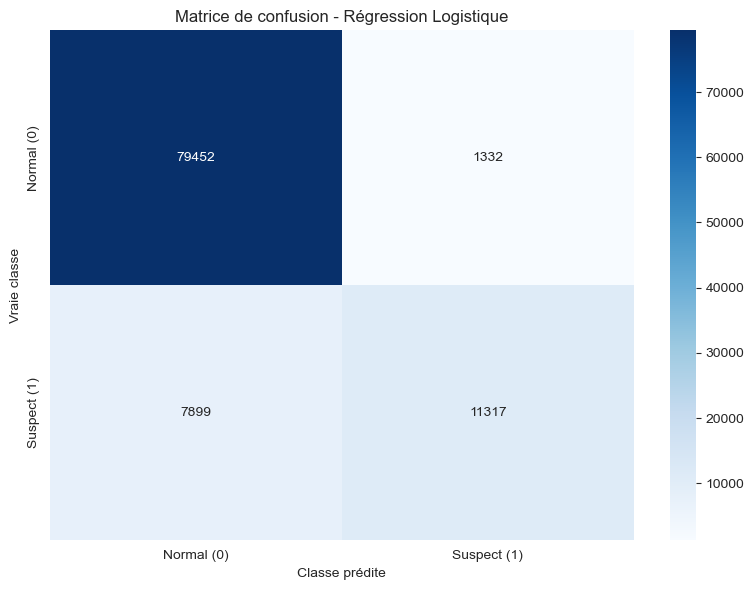

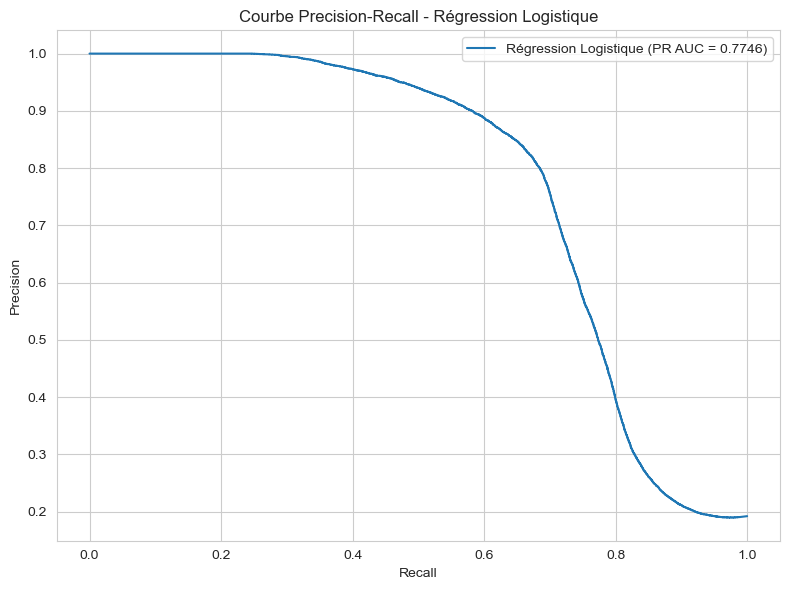

In [53]:
# Classification report
print("=== CLASSIFICATION REPORT - RÉGRESSION LOGISTIQUE ===\n")
print(classification_report(y_test, y_pred_lr, target_names=['Normal (0)', 'Suspect (1)']))

# ROC AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nROC AUC Score : {roc_auc_lr:.4f}")

# PR AUC (Average Precision)
pr_auc_lr = average_precision_score(y_test, y_pred_proba_lr)
print(f"PR AUC (Average Precision) Score : {pr_auc_lr:.4f}")

# Matrice de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (0)', 'Suspect (1)'],
            yticklabels=['Normal (0)', 'Suspect (1)'])
plt.title('Matrice de confusion - Régression Logistique')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.show()

# Courbe Precision-Recall
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Régression Logistique (PR AUC = {pr_auc_lr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Régression Logistique')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Résultats : Random Forest


=== CLASSIFICATION REPORT - RANDOM FOREST ===

              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     80784
 Suspect (1)       1.00      1.00      1.00     19216

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000


ROC AUC Score : 1.0000
PR AUC (Average Precision) Score : 1.0000


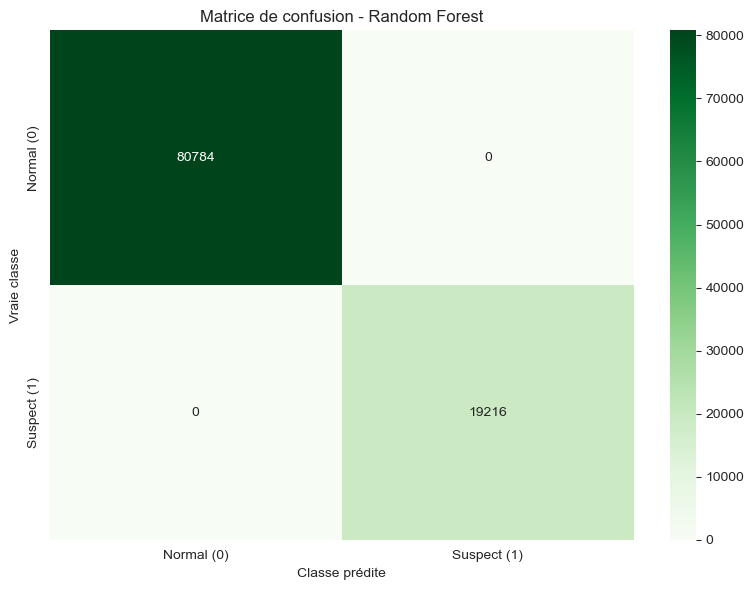

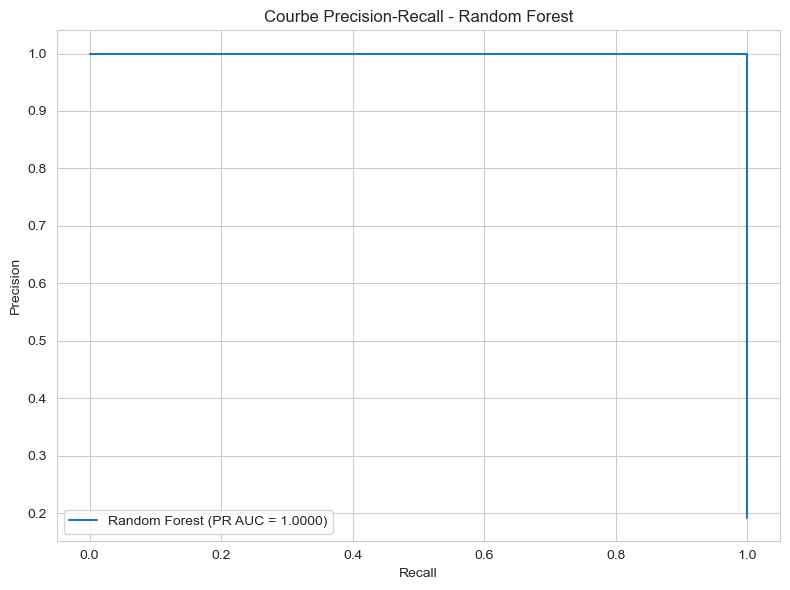

In [54]:
# Classification report
print("=== CLASSIFICATION REPORT - RANDOM FOREST ===\n")
print(classification_report(y_test, y_pred_rf, target_names=['Normal (0)', 'Suspect (1)']))

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nROC AUC Score : {roc_auc_rf:.4f}")

# PR AUC (Average Precision)
pr_auc_rf = average_precision_score(y_test, y_pred_proba_rf)
print(f"PR AUC (Average Precision) Score : {pr_auc_rf:.4f}")

# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal (0)', 'Suspect (1)'],
            yticklabels=['Normal (0)', 'Suspect (1)'])
plt.title('Matrice de confusion - Random Forest')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.show()

# Courbe Precision-Recall
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (PR AUC = {pr_auc_rf:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Choix d’un seuil pour atteindre un rappel cible (ex: 0.80) sur la classe suspecte
target_recall = 0.80

# Split interne depuis (X_train, y_train) en train_sub et val
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=42
)

# Entraînement d'un nouveau pipeline LR sur train_sub (mêmes hyperparams, même preprocessor)
pipeline_lr_threshold = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=200, random_state=42))
])
pipeline_lr_threshold.fit(X_train_sub, y_train_sub)

# Prédictions sur val pour choisir le seuil
y_pred_proba_val = pipeline_lr_threshold.predict_proba(X_val)[:, 1]

# Choix du seuil sur val pour atteindre target_recall
thresholds = np.linspace(0.01, 0.99, 99)
best = None
for t in thresholds:
    y_pred_t = (y_pred_proba_val >= t).astype(int)
    r = recall_score(y_val, y_pred_t)
    if r >= target_recall:
        best = t
        break

if best is None:
    print("Aucun seuil ne permet d'atteindre le rappel cible avec ce modèle.")
else:
    threshold = best
    # Évaluation uniquement à la fin sur le vrai (X_test, y_test)
    y_pred_proba_test = pipeline_lr_threshold.predict_proba(X_test)[:, 1]
    y_pred_test = (y_pred_proba_test >= threshold).astype(int)
    p = precision_score(y_test, y_pred_test, zero_division=0)
    r = recall_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"Seuil choisi (LR) pour recall >= {target_recall:.2f} : {threshold:.2f}")
    print(f"Precision: {p:.3f} | Recall: {r:.3f}")
    print("Confusion matrix:\n", cm)


Seuil choisi (LR) pour recall >= 0.80 : 0.01
Precision: 0.192 | Recall: 1.000
Confusion matrix:
 [[    0 80784]
 [    0 19216]]


**Note sur `zero_division=0` et le choix du seuil :** 

Le paramètre `zero_division=0` dans `classification_report` et `precision_score` évite les warnings lorsque aucune prédiction n'est faite pour une classe (cas de la baseline qui prédit toujours 0). Le seuil doit être choisi sur un ensemble de validation (et non sur le test) pour éviter le data leakage : choisir le seuil sur le test set donnerait une estimation optimiste et biaisée des performances réelles du modèle.


### Comparaison des Modèles - Partie A


In [56]:
# Comparaison des ROC AUC et PR AUC
print("=== COMPARAISON DES MODÈLES ===\n")
print(f"Régression Logistique - ROC AUC : {roc_auc_lr:.4f}")
print(f"Régression Logistique - PR AUC : {pr_auc_lr:.4f}")
print(f"Random Forest - ROC AUC : {roc_auc_rf:.4f}")
print(f"Random Forest - PR AUC : {pr_auc_rf:.4f}")

# Extraction des métriques pour comparaison
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_lr = {
    'Précision (classe 1)': precision_score(y_test, y_pred_lr),
    'Rappel (classe 1)': recall_score(y_test, y_pred_lr),
    'F1-Score (classe 1)': f1_score(y_test, y_pred_lr),
    'ROC AUC': roc_auc_lr,
    'PR AUC': pr_auc_lr
}

metrics_rf = {
    'Précision (classe 1)': precision_score(y_test, y_pred_rf),
    'Rappel (classe 1)': recall_score(y_test, y_pred_rf),
    'F1-Score (classe 1)': f1_score(y_test, y_pred_rf),
    'ROC AUC': roc_auc_rf,
    'PR AUC': pr_auc_rf
}

comparison_df = pd.DataFrame({
    'Régression Logistique': metrics_lr,
    'Random Forest': metrics_rf
})

print("\n=== MÉTRIQUES COMPARÉES (classe suspecte) ===")
print(comparison_df)


=== COMPARAISON DES MODÈLES ===

Régression Logistique - ROC AUC : 0.8313
Régression Logistique - PR AUC : 0.7746
Random Forest - ROC AUC : 1.0000
Random Forest - PR AUC : 1.0000

=== MÉTRIQUES COMPARÉES (classe suspecte) ===
                      Régression Logistique  Random Forest
Précision (classe 1)               0.894695            1.0
Rappel (classe 1)                  0.588936            1.0
F1-Score (classe 1)                0.710309            1.0
ROC AUC                            0.831338            1.0
PR AUC                             0.774577            1.0


**Interprétation des résultats - Partie A :**

**Important à comprendre :** Les modèles apprennent principalement à **approximer les règles** qui ont servi à construire `is_suspicious` (percentiles sur `amount` et `gas_fee_usd`, self-transfers). Les scores élevés (ROC AUC, précision, rappel) ne prouvent **pas** une détection de fraude réelle mais plutôt la capacité du modèle à reproduire ces règles arbitraires.
Autrement dit, **le modèle n’apprend pas un phénomène latent de fraude** mais une fonction quasi déterministe définie a priori par le processus de labellisation.

**Analyse des performances :**

1. **Rappel (Recall) pour la classe suspecte** : Indique la proportion de transactions marquées comme suspectes par nos règles qui sont correctement identifiées par le modèle. Un rappel élevé signifie que le modèle capture bien les patterns définis par nos règles synthétiques.

2. **Précision (Precision) pour la classe suspecte** : Indique la proportion de transactions prédites comme suspectes qui correspondent réellement aux règles synthétiques.

3. **ROC AUC** : Mesure globale de la capacité du modèle à distinguer les deux classes selon nos règles. Un score proche de 1 indique que le modèle reproduit bien les règles, pas qu'il détecte de vraies fraudes.

**Limites importantes :**
- Les labels sont **synthétiques** : construits à partir des mêmes variables que celles utilisées par le modèle, ce qui entraîne un apprentissage circulaire et des performances artificiellement élevées. Le modèle apprend à reproduire des règles arbitraires, pas à détecter de vraies fraudes. 
- Cette approche est **pédagogique** : elle illustre un pipeline supervisé classique, mais dans la réalité on n'a généralement pas de labels disponibles.
- Les **features utilisées sont limitées** (pas d'historique par adresse, pas de graphes de transactions).


### What would break this model?

Nous testons la robustesse du modèle en effectuant des ablations : on retire une feature importante à la fois pour voir l'impact sur les performances.


In [57]:
# Ablation A1 : Sans amount
features_no_amount = ['token', 'platform', 'tx_type', 'gas_fee_usd', 'is_self_transfer']
preprocessor_no_amount = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['token', 'platform', 'tx_type']),
        ('num', StandardScaler(), ['gas_fee_usd', 'is_self_transfer'])
    ],
    remainder='drop'
)
pipeline_lr_no_amount = Pipeline([
    ('preprocessor', preprocessor_no_amount),
    ('model', LogisticRegression(max_iter=200, random_state=42))
])
X_train_no_amount = df_train[features_no_amount]
X_test_no_amount = df_test[features_no_amount]
pipeline_lr_no_amount.fit(X_train_no_amount, y_train)
y_pred_proba_no_amount = pipeline_lr_no_amount.predict_proba(X_test_no_amount)[:, 1]
roc_auc_no_amount = roc_auc_score(y_test, y_pred_proba_no_amount)
pr_auc_no_amount = average_precision_score(y_test, y_pred_proba_no_amount)
print(f"Ablation without amount: ROC AUC={roc_auc_no_amount:.4f}, PR AUC={pr_auc_no_amount:.4f}")

# Ablation A2 : Sans gas_fee_usd
features_no_gas = ['token', 'platform', 'tx_type', 'amount', 'is_self_transfer']
preprocessor_no_gas = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['token', 'platform', 'tx_type']),
        ('num', StandardScaler(), ['amount', 'is_self_transfer'])
    ],
    remainder='drop'
)
pipeline_lr_no_gas = Pipeline([
    ('preprocessor', preprocessor_no_gas),
    ('model', LogisticRegression(max_iter=200, random_state=42))
])
X_train_no_gas = df_train[features_no_gas]
X_test_no_gas = df_test[features_no_gas]
pipeline_lr_no_gas.fit(X_train_no_gas, y_train)
y_pred_proba_no_gas = pipeline_lr_no_gas.predict_proba(X_test_no_gas)[:, 1]
roc_auc_no_gas = roc_auc_score(y_test, y_pred_proba_no_gas)
pr_auc_no_gas = average_precision_score(y_test, y_pred_proba_no_gas)
print(f"Ablation without gas_fee_usd: ROC AUC={roc_auc_no_gas:.4f}, PR AUC={pr_auc_no_gas:.4f}")


Ablation without amount: ROC AUC=0.7668, PR AUC=0.6887
Ablation without gas_fee_usd: ROC AUC=0.4981, PR AUC=0.4214


---

## PARTIE B - Approche Réaliste sans Labels (Non Supervisé → Pseudo-Labels → Supervisé)

Dans cette deuxième partie, nous illustrons une approche plus réaliste : **pas de labels au départ**. 

**Stratégie :**
1. Utiliser un modèle de **détection d'anomalies non supervisé** (IsolationForest) pour produire un score de suspicion
2. Créer des **pseudo-labels** à partir de ce score
3. Entraîner un modèle **supervisé** sur ces pseudo-labels (démonstration)

**Intérêt :** Cette approche permet de **prioriser** les transactions à investiguer manuellement, puis de collecter de vrais labels pour entraîner un modèle supervisé final.


### Préparation des données pour la Partie B

Nous repartons du dataset brut **sans utiliser les labels synthétiques de la Partie A**. Nous créons un nouveau DataFrame pour la Partie B.


In [58]:
# Rechargement du dataset brut (sans les labels synthétiques de la Partie A)
df_unlabeled = pd.read_csv('../data/raw/crypto_transactions.csv')

# Division train/test EN AMONT pour éviter la fuite de données
# On utilise le même random_state que Partie A pour la cohérence
df_train_unlabeled, df_test_unlabeled = train_test_split(
    df_unlabeled, 
    test_size=0.2, 
    random_state=42
)

# Sécurisation (évite SettingWithCopy et comportements bizarres)
df_train_unlabeled = df_train_unlabeled.copy()
df_test_unlabeled  = df_test_unlabeled.copy()

print(f"Dataset brut pour Partie B : {df_unlabeled.shape[0]} transactions")
print(f"Train set : {df_train_unlabeled.shape[0]} échantillons")
print(f"Test set : {df_test_unlabeled.shape[0]} échantillons")
print(f"Colonnes disponibles : {list(df_unlabeled.columns)}")
df_train_unlabeled.head()


Dataset brut pour Partie B : 500000 transactions
Train set : 400000 échantillons
Test set : 100000 échantillons
Colonnes disponibles : ['tx_hash', 'from_wallet', 'to_wallet', 'token', 'amount', 'timestamp', 'gas_fee_usd', 'platform', 'tx_type']


,tx_hash,from_wallet,to_wallet,token,amount,timestamp,gas_fee_usd,platform,tx_type
269056,0x1bc05eb4e289d7d9f9f983ec95b1a3be7b601ed0f2e4...,0xf03b2774539f2adaf8571ed0a19196fc525aed51,0x2fb1259b9f5da6474d215fb3a9e80488c865a0c5,SHIB,0.901821,2022-04-01 06:47:57,2.9881,OpenSea,borrow
499174,0x2bf0db321cddddbbbc60cef3d86a340d9793707e5c2d...,0x9b401630c221fc337d202f935b15c59961b8b159,0x80a545564a3e69c4cec96a2edb4eca9f2fc45ee9,USDT,3.069333,2022-10-31 00:35:25,3.4360,Aave,stake
85143,0xb36f79feaf06e5d71d9540b44ceec9abc15bdd09fc38...,0x01612d44a84acd6439c33db32d27cee2221c83c4,0x2d3bda1edadc3bc06a63040132d54b3814765267,DAI,0.431661,2022-03-07 03:13:11,1.0552,Balancer,transfer
260335,0xf4e1917c40c540bb039372771dec98e5b10fa8a21b57...,0x5115ce63596cef400c643841f578e1eb05c3a556,0xa3b60747e4ad3ce0cc2af2435f84def57ea4e019,USDC,10.815181,2022-12-14 11:11:11,1.7879,Aave,stake
338124,0x53b94cf7d4e87371807deddbc8154389c344ed77d548...,0x14d3b1dfc6fd3d8266ca38da5ce68737f5a021a9,0x2e7e6cc4963391fe153abd965fb9b121b2d9222a,MATIC,8.501229,2022-05-29 20:58:14,0.1428,OpenSea,mint


### Détection d'Anomalies Non Supervisée (IsolationForest)

Nous utilisons **IsolationForest** pour détecter les transactions anormales sans avoir besoin de labels. 

**Principe :** IsolationForest isole les observations anormales en identifiant celles qui sont faciles à isoler du reste des données. Plus une observation est facile à isoler, plus elle est considérée comme anormale.

**Paramètre `contamination` :** Proportion attendue d'anomalies dans le dataset. Nous utilisons `contamination=0.01` (1% d'anomalies), ce qui est plus réaliste pour un contexte de fraude où les transactions suspectes sont rares. Cette valeur peut être ajustée selon le contexte métier.


In [59]:
# Feature simple : self-transfer
df_train_unlabeled['is_self_transfer'] = (df_train_unlabeled['from_wallet'] == df_train_unlabeled['to_wallet']).astype(int)
df_test_unlabeled['is_self_transfer']  = (df_test_unlabeled['from_wallet'] == df_test_unlabeled['to_wallet']).astype(int)

print("\nSelf-transfer rate (train) :", df_train_unlabeled['is_self_transfer'].mean())
print("Self-transfer rate (test)  :", df_test_unlabeled['is_self_transfer'].mean())

# Sélection des features pour la détection d'anomalies
# Mêmes features que Partie A pour la cohérence
categorical_features_b = ['token', 'platform', 'tx_type']
numerical_features_b = ['amount', 'gas_fee_usd', 'is_self_transfer']

# Utilisation uniquement du train set pour l'entraînement
X_train_unlabeled = df_train_unlabeled[categorical_features_b + numerical_features_b]


# Création du préprocesseur (identique à Partie A)
preprocessor_b = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_b),
        ('num', StandardScaler(), numerical_features_b)
    ],
    remainder='drop'
)

# Pipeline avec IsolationForest
# contamination=0.01 signifie qu'on s'attend à ~1% d'anomalies (plus réaliste)
pipeline_anomaly = Pipeline([
    ('preprocessor', preprocessor_b),
    ('anomaly_detector', IsolationForest(
        contamination=0.01, 
        random_state=42,
        n_estimators=100
    ))
])

print("Entraînement du modèle de détection d'anomalies sur le train set...")
pipeline_anomaly.fit(X_train_unlabeled)
print("Entraînement terminé !")

# Prédictions sur le train set : -1 = anomalie, 1 = normal
anomaly_predictions_train = pipeline_anomaly.predict(X_train_unlabeled)
anomaly_scores_train = pipeline_anomaly.decision_function(X_train_unlabeled)

# Prédictions sur le test set (sans refit) : -1 = anomalie, 1 = normal
X_test_unlabeled = df_test_unlabeled[categorical_features_b + numerical_features_b]
anomaly_predictions_test = pipeline_anomaly.predict(X_test_unlabeled)
anomaly_scores_test = pipeline_anomaly.decision_function(X_test_unlabeled)

# Création des pseudo-labels : 1 = suspect (anomalie), 0 = normal
df_train_unlabeled['pseudo_is_suspicious'] = (anomaly_predictions_train == -1).astype(int)
df_test_unlabeled['pseudo_is_suspicious'] = (anomaly_predictions_test == -1).astype(int)

# (Optionnel mais utile) stocker les scores dans les df pour analyses
df_train_unlabeled['anomaly_score'] = anomaly_scores_train
df_test_unlabeled['anomaly_score'] = anomaly_scores_test

# Réunion pour l'affichage
df_unlabeled = pd.concat([df_train_unlabeled, df_test_unlabeled], ignore_index=True)
anomaly_scores = np.concatenate([anomaly_scores_train, anomaly_scores_test])

print(f"\nNombre de transactions détectées comme anomalies (train) : {(anomaly_predictions_train == -1).sum()}")
print(f"Nombre de transactions détectées comme anomalies (test) : {(anomaly_predictions_test == -1).sum()}")
print(f"Pourcentage d'anomalies détectées (train) : {(anomaly_predictions_train == -1).mean()*100:.2f}%")
print(f"Pourcentage d'anomalies détectées (test) : {(anomaly_predictions_test == -1).mean()*100:.2f}%")



Self-transfer rate (train) : 0.0001025
Self-transfer rate (test)  : 0.00014
Entraînement du modèle de détection d'anomalies sur le train set...
Entraînement terminé !

Nombre de transactions détectées comme anomalies (train) : 4000
Nombre de transactions détectées comme anomalies (test) : 1005
Pourcentage d'anomalies détectées (train) : 1.00%
Pourcentage d'anomalies détectées (test) : 1.00%


### EDA sur les Pseudo-Labels

Analysons rapidement la distribution des pseudo-labels créés par IsolationForest et examinons quelques exemples de transactions les plus "anormales".


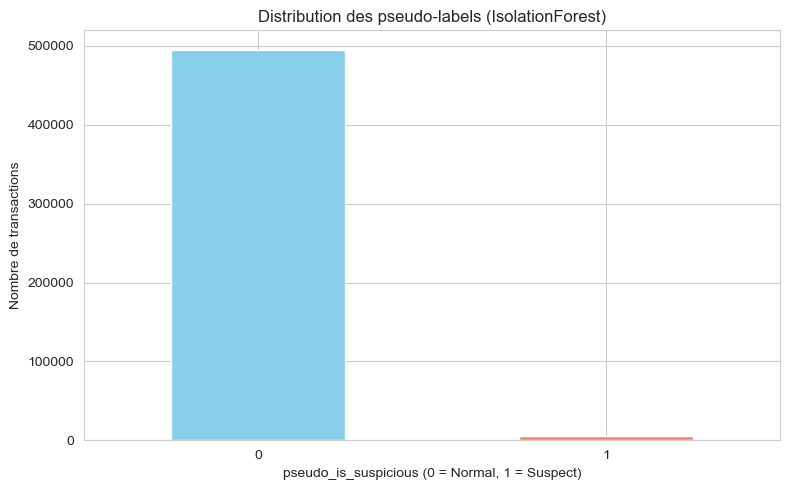


=== Top 10 transactions les plus anormales (scores les plus négatifs) ===
         tx_type token   platform     amount  gas_fee_usd  is_self_transfer  \
159375     stake   ETH   Balancer  32.796252       8.4845                 0   
125937     stake   ETH    Uniswap  32.558187      10.2034                 0   
104502     stake   ETH      Curve  29.795635      14.7761                 0   
23838       burn   ETH   Balancer  25.433967       9.7365                 0   
130942     stake   ETH      1inch  44.892641       5.9257                 0   
112626    borrow   UNI   Balancer  44.291517      10.4351                 0   
366050      mint   ETH   Compound  27.652075      13.4609                 0   
300814     stake   ETH      1inch  35.879157       4.9539                 0   
399886  transfer   UNI  Sushiswap  45.382396      13.2113                 0   
89894   transfer  WBTC   Compound  69.192232      19.3391                 0   

        pseudo_is_suspicious  anomaly_score  
159375   

In [60]:
# Distribution des pseudo-labels
plt.figure(figsize=(8, 5))
df_unlabeled['pseudo_is_suspicious'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution des pseudo-labels (IsolationForest)')
plt.xlabel('pseudo_is_suspicious (0 = Normal, 1 = Suspect)')
plt.ylabel('Nombre de transactions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Affichage des transactions les plus "anormales" (scores les plus négatifs)
print("\n=== Top 10 transactions les plus anormales (scores les plus négatifs) ===")
top_anomalies_idx = np.argsort(anomaly_scores)[:10]
top_anomalies = df_unlabeled.iloc[top_anomalies_idx][
    ['tx_type', 'token', 'platform', 'amount', 'gas_fee_usd', 'is_self_transfer', 'pseudo_is_suspicious']
].copy()
top_anomalies['anomaly_score'] = anomaly_scores[top_anomalies_idx]
top_anomalies = top_anomalies.sort_values('anomaly_score')
print(top_anomalies)


**Interprétation :** IsolationForest a identifié environ 1% des transactions comme anormales (selon le paramètre `contamination=0.01`). Ces transactions peuvent être investiguées manuellement pour valider si elles sont réellement suspectes, puis servir à créer de vrais labels pour un modèle supervisé final. Cette approche permet de prioriser les investigations sur un petit nombre de transactions plutôt que de tout examiner.

### Pipeline Supervisé sur Pseudo-Labels (Démonstration)

Maintenant, nous entraînons un modèle supervisé sur les pseudo-labels créés par IsolationForest. 

**Objectif :** Démontrer comment on peut utiliser des pseudo-labels pour entraîner un modèle supervisé.

**Limite importante :** Le modèle supervisé apprend à reproduire le signal généré par IsolationForest. Il y a un risque de circularité : on apprend à prédire ce qu'un autre modèle a déjà identifié. Dans la pratique, les pseudo-labels devraient être validés par des experts humains avant d'entraîner un modèle supervisé.


In [61]:
# Définition de X et y pour le modèle supervisé
# On utilise les ensembles train/test déjà créés (séparés en amont)
X_train_pseudo = df_train_unlabeled[categorical_features_b + numerical_features_b]
y_train_pseudo = df_train_unlabeled['pseudo_is_suspicious']
X_test_pseudo = df_test_unlabeled[categorical_features_b + numerical_features_b]
y_test_pseudo = df_test_unlabeled['pseudo_is_suspicious']

print(f"Train set : {X_train_pseudo.shape[0]} échantillons")
print(f"Test set : {X_test_pseudo.shape[0]} échantillons")
print(f"\nProportion de pseudo-fraudes dans le train : {y_train_pseudo.mean():.3f}")
print(f"Proportion de pseudo-fraudes dans le test : {y_test_pseudo.mean():.3f}")


Train set : 400000 échantillons
Test set : 100000 échantillons

Proportion de pseudo-fraudes dans le train : 0.010
Proportion de pseudo-fraudes dans le test : 0.010


### Modèles Supervisés sur Pseudo-Labels


In [62]:
# Pipeline avec Régression Logistique
pipeline_lr_pseudo = Pipeline([
    ('preprocessor', preprocessor_b),
    ('model', LogisticRegression(max_iter=200, random_state=42))
])

print("Entraînement de la régression logistique sur pseudo-labels...")
pipeline_lr_pseudo.fit(X_train_pseudo, y_train_pseudo)
y_pred_lr_pseudo = pipeline_lr_pseudo.predict(X_test_pseudo)
y_pred_proba_lr_pseudo = pipeline_lr_pseudo.predict_proba(X_test_pseudo)[:, 1]

# Pipeline avec Random Forest
pipeline_rf_pseudo = Pipeline([
    ('preprocessor', preprocessor_b),
    ('model', RandomForestClassifier(random_state=42))
])

print("Entraînement du Random Forest sur pseudo-labels...")
pipeline_rf_pseudo.fit(X_train_pseudo, y_train_pseudo)
y_pred_rf_pseudo = pipeline_rf_pseudo.predict(X_test_pseudo)
y_pred_proba_rf_pseudo = pipeline_rf_pseudo.predict_proba(X_test_pseudo)[:, 1]

print("\nEntraînement terminé !")


Entraînement de la régression logistique sur pseudo-labels...
Entraînement du Random Forest sur pseudo-labels...

Entraînement terminé !


### Évaluation des Modèles sur Pseudo-Labels


=== RÉGRESSION LOGISTIQUE (sur pseudo-labels) ===

              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      1.00     98995
 Suspect (1)       0.74      0.45      0.56      1005

    accuracy                           0.99    100000
   macro avg       0.87      0.73      0.78    100000
weighted avg       0.99      0.99      0.99    100000

ROC AUC : 0.9923
PR AUC (Average Precision) : 0.6375



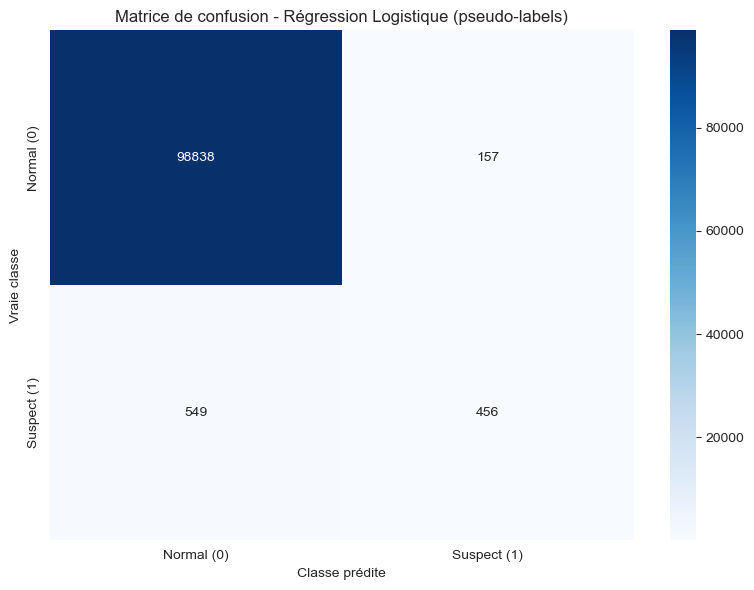

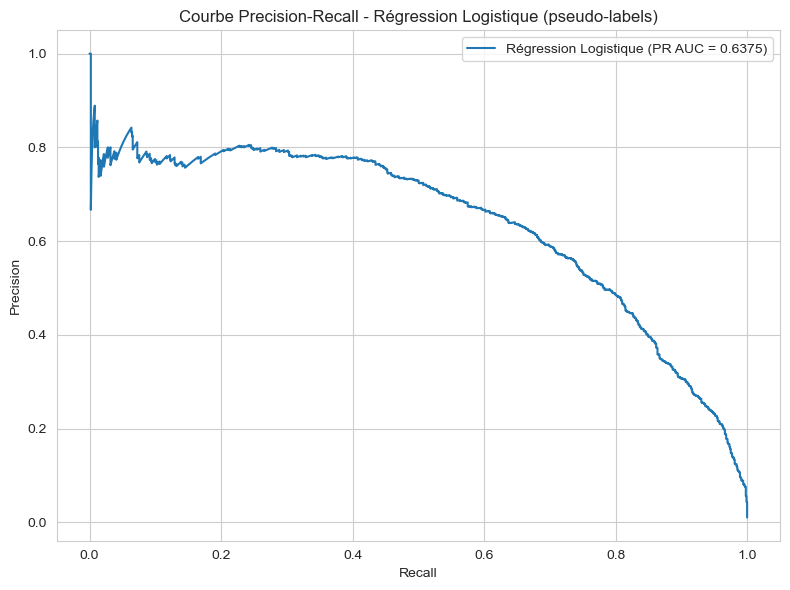

In [63]:
# Évaluation Régression Logistique
print("=== RÉGRESSION LOGISTIQUE (sur pseudo-labels) ===\n")
print(classification_report(y_test_pseudo, y_pred_lr_pseudo, target_names=['Normal (0)', 'Suspect (1)']))
roc_auc_lr_pseudo = roc_auc_score(y_test_pseudo, y_pred_proba_lr_pseudo)
pr_auc_lr_pseudo = average_precision_score(y_test_pseudo, y_pred_proba_lr_pseudo)
print(f"ROC AUC : {roc_auc_lr_pseudo:.4f}")
print(f"PR AUC (Average Precision) : {pr_auc_lr_pseudo:.4f}\n")

cm_lr_pseudo = confusion_matrix(y_test_pseudo, y_pred_lr_pseudo)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_pseudo, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Suspect (1)'],
            yticklabels=['Normal (0)', 'Suspect (1)'])
plt.title('Matrice de confusion - Régression Logistique (pseudo-labels)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.show()

# Courbe Precision-Recall
precision_lr_pseudo, recall_lr_pseudo, _ = precision_recall_curve(y_test_pseudo, y_pred_proba_lr_pseudo)
plt.figure(figsize=(8, 6))
plt.plot(recall_lr_pseudo, precision_lr_pseudo, label=f'Régression Logistique (PR AUC = {pr_auc_lr_pseudo:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Régression Logistique (pseudo-labels)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### What would break this model? (contamination sensitivity)

Nous testons la sensibilité du modèle IsolationForest à différents niveaux de contamination pour voir comment cela affecte la détection d'anomalies.


In [64]:
# Pipeline avec contamination=0.05
pipeline_anomaly_whatif = Pipeline([
    ('preprocessor', preprocessor_b),
    ('anomaly', IsolationForest(contamination=0.05, random_state=42))
])

print("Entraînement du modèle de détection d'anomalies avec contamination=0.05 sur le train set...")
pipeline_anomaly_whatif.fit(X_train_unlabeled)
print("Entraînement terminé !")

# Prédictions sur le train set
anomaly_predictions_train_whatif = pipeline_anomaly_whatif.predict(X_train_unlabeled)
anomaly_scores_train_whatif = pipeline_anomaly_whatif.decision_function(X_train_unlabeled)

# Prédictions sur le test set (sans refit)
anomaly_predictions_test_whatif = pipeline_anomaly_whatif.predict(X_test_unlabeled)
anomaly_scores_test_whatif = pipeline_anomaly_whatif.decision_function(X_test_unlabeled)

print(f"\nPourcentage d'anomalies détectées (train) : {(anomaly_predictions_train_whatif == -1).mean()*100:.2f}%")
print(f"Pourcentage d'anomalies détectées (test) : {(anomaly_predictions_test_whatif == -1).mean()*100:.2f}%")

# Top 5 anomalies (scores les plus négatifs) sur le dataset concaténé
df_unlabeled_whatif = pd.concat([df_train_unlabeled, df_test_unlabeled], ignore_index=True)
anomaly_scores_whatif = np.concatenate([anomaly_scores_train_whatif, anomaly_scores_test_whatif])
df_unlabeled_whatif['anomaly_score_whatif'] = anomaly_scores_whatif
top5_anomalies_whatif = df_unlabeled_whatif.nsmallest(5, 'anomaly_score_whatif')
print("\n=== Top 5 anomalies (scores les plus négatifs) ===")
print(top5_anomalies_whatif[['tx_hash', 'amount', 'gas_fee_usd', 'anomaly_score_whatif']])


Entraînement du modèle de détection d'anomalies avec contamination=0.05 sur le train set...
Entraînement terminé !

Pourcentage d'anomalies détectées (train) : 5.00%
Pourcentage d'anomalies détectées (test) : 4.98%

=== Top 5 anomalies (scores les plus négatifs) ===
                                                  tx_hash     amount  \
159375  0x4ec9a9869b36c6432fc6da2a1aa948e59c9b6ade271d...  32.796252   
125937  0xc958820275a510aac151b057ee87f1940375187d2dcd...  32.558187   
104502  0x518fe38dbd14dc6cb48fa85a6d0f8f035d3a91ff4327...  29.795635   
23838   0x3bb02275898505098ee6ba09c9430bf126a313f87726...  25.433967   
130942  0x196a013fb52565a355f3f23460a1c35b5fe242c3685b...  44.892641   

        gas_fee_usd  anomaly_score_whatif  
159375       8.4845             -0.079051  
125937      10.2034             -0.069137  
104502      14.7761             -0.067925  
23838        9.7365             -0.066992  
130942       5.9257             -0.064935  


=== RANDOM FOREST (sur pseudo-labels) ===

              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     98995
 Suspect (1)       0.96      0.78      0.86      1005

    accuracy                           1.00    100000
   macro avg       0.98      0.89      0.93    100000
weighted avg       1.00      1.00      1.00    100000

ROC AUC : 0.9995
PR AUC (Average Precision) : 0.9581



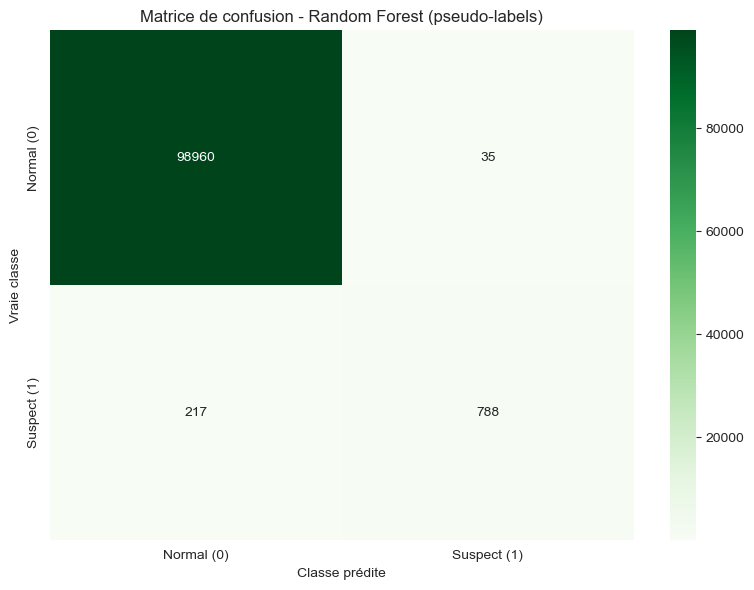

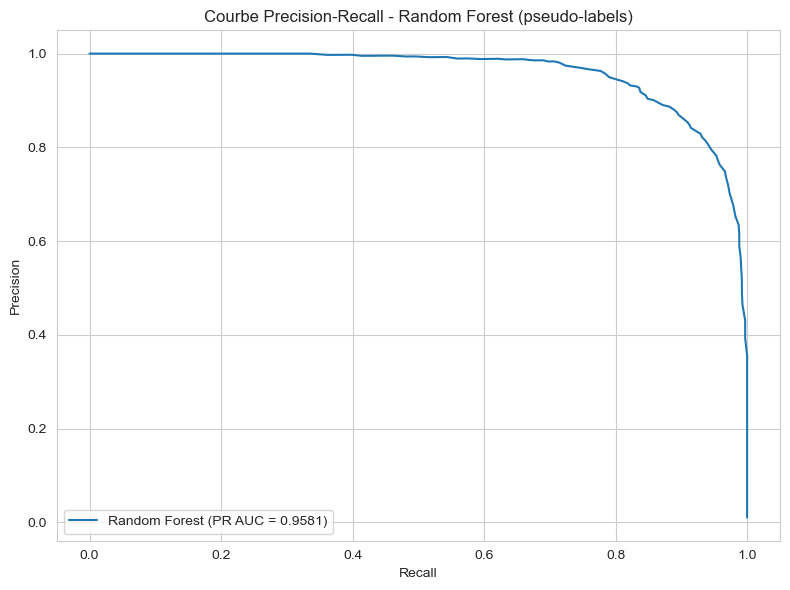

In [65]:
# Évaluation Random Forest
print("=== RANDOM FOREST (sur pseudo-labels) ===\n")
print(classification_report(y_test_pseudo, y_pred_rf_pseudo, target_names=['Normal (0)', 'Suspect (1)']))
roc_auc_rf_pseudo = roc_auc_score(y_test_pseudo, y_pred_proba_rf_pseudo)
pr_auc_rf_pseudo = average_precision_score(y_test_pseudo, y_pred_proba_rf_pseudo)
print(f"ROC AUC : {roc_auc_rf_pseudo:.4f}")
print(f"PR AUC (Average Precision) : {pr_auc_rf_pseudo:.4f}\n")

cm_rf_pseudo = confusion_matrix(y_test_pseudo, y_pred_rf_pseudo)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_pseudo, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal (0)', 'Suspect (1)'],
            yticklabels=['Normal (0)', 'Suspect (1)'])
plt.title('Matrice de confusion - Random Forest (pseudo-labels)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.show()

# Courbe Precision-Recall
precision_rf_pseudo, recall_rf_pseudo, _ = precision_recall_curve(y_test_pseudo, y_pred_proba_rf_pseudo)
plt.figure(figsize=(8, 6))
plt.plot(recall_rf_pseudo, precision_rf_pseudo, label=f'Random Forest (PR AUC = {pr_auc_rf_pseudo:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Random Forest (pseudo-labels)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Interprétation - Partie B :**

Les modèles supervisés entraînés sur les pseudo-labels apprennent à reproduire le signal généré par IsolationForest. Les performances reflètent donc la capacité du modèle à identifier les mêmes patterns que le détecteur d'anomalies.

**Limites et considérations :**
- **Risque de circularité** : Le modèle supervisé apprend à prédire ce qu'un autre modèle (IsolationForest) a déjà identifié. Il n'apprend pas nécessairement à détecter de vraies fraudes.
- **Utilité pédagogique** : Cette approche illustre comment on peut utiliser des pseudo-labels pour bootstrapper un modèle supervisé.
- **Approche réaliste** : Dans la pratique, les transactions identifiées par IsolationForest devraient être investiguées manuellement pour créer de vrais labels, puis un modèle supervisé final serait entraîné sur ces labels validés.

---

## Conclusion

### Résumé des deux approches

**PARTIE A : Supervised ML avec labels synthétiques :**
- Création de labels synthétiques basés sur des règles simples (percentiles, self-transfers)
- Pipeline supervisé classique (LogisticRegression + RandomForest)
- **Utilité :** Pédagogique, illustre un workflow ML supervisé standard
- **Limite :** Les labels sont arbitraires et ne reflètent pas de vraies fraudes

**PARTIE B : Approche réaliste sans labels :**
- Détection d'anomalies non supervisée (IsolationForest) pour créer des pseudo-labels
- Pipeline supervisé entraîné sur ces pseudo-labels
- **Utilité :** Approche plus réaliste, permet de prioriser les transactions à investiguer
- **Limite :** Risque de circularité si les pseudo-labels ne sont pas validés par des experts

### Workflow réaliste recommandé

1. **Scoring/Anomaly Detection** : Utiliser IsolationForest (ou autres méthodes) pour scorer les transactions
2. **Priorisation** : Trier les transactions par score de suspicion décroissant
3. **Collecte de labels** : Faire investiguer manuellement les transactions les plus suspectes par des experts
4. **Supervised/Semi-Supervised** : Entraîner un modèle supervisé final sur les labels validés, ou utiliser des approches semi-supervisées

### Axes d'amélioration

1. **Features par wallet** : Agrégations temporelles (nombre de transactions, montant moyen, réputation) pour chaque adresse
2. **Temporalité / Séquences** : Modèles capables de capturer les patterns temporels et les séquences de transactions
3. **Validation humaine / Vrai dataset labellisé** : Collecter de vrais labels validés par des experts pour entraîner un modèle supervisé robuste

---

**Note finale :** Ce notebook sert de **baseline pédagogique** illustrant deux approches complémentaires. Dans un contexte de production, il faudrait approfondir chaque étape, valider avec des données réelles et intégrer le modèle dans un pipeline de monitoring continu avec validation humaine.
